In [1]:
from sar_sim import *
import numpy as np

In [34]:
# Define SAR sensor parameters
sensor = SensorParameters(
    carrier_frequency_hz=360e6,
    bandwidth_hz=500e6,
    pulse_width_s=5e-6,
    PRF_hz=10_000,
    sampling_frequency_hz=3e9,
    sensor_speed_mps=7500.0,
    sensor_height_m=100_000.0,
    grazing_angle_deg=40.0,
    swath_m=5_000.0,
    range_width_m=5_000.0,
    azimuth_resolution_m=1.0,
    integration_angle_rad=calculate_integration_angle(1.2, 3e8/360e6, 1.0)
)

# Define a single point target at an offset
target_pos = (0.0, 0.0, 0.0)


In [35]:
# Simulate raw SAR data
raw_data = simulate_raw_data(sensor, target_pos)

# Compute time delays for the target
time_result_target = compute_target_time_delays(sensor, target_pos)

Suggested xlim: (0.0 μs, 5.0 μs)


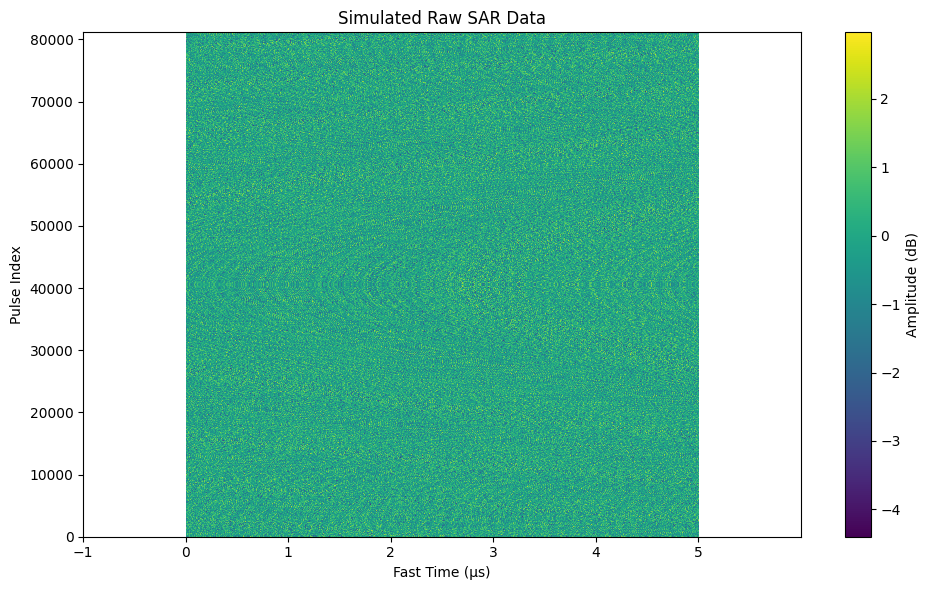

In [36]:
# Plot SAR raw data (Pulse Index vs Fast Time)
plot_raw_sar_data(raw_data, sensor.sampling_frequency_hz, downsample_fast=20)

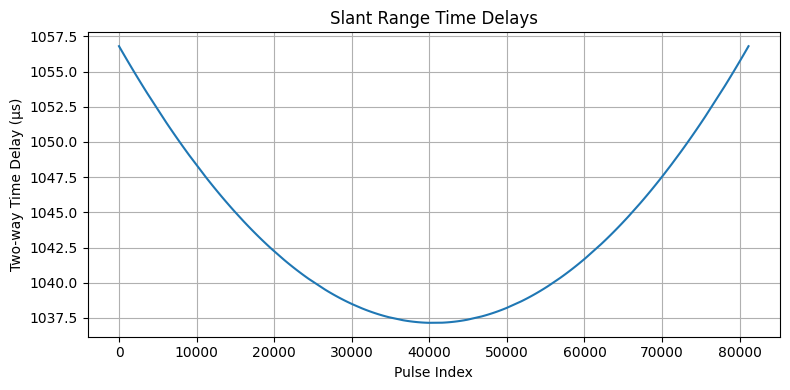

In [37]:
# Plot time delay of the target
plot_slant_range_time_delays(time_result_target)

In [38]:
# Perform range migration alignment
aligned_data = perform_range_migration(
    compressed_data=raw_data,
    sensor=sensor,
    target_position=target_pos,
    sampling_frequency=sensor.sampling_frequency_hz
)



Suggested xlim: (0.0 μs, 5.0 μs)


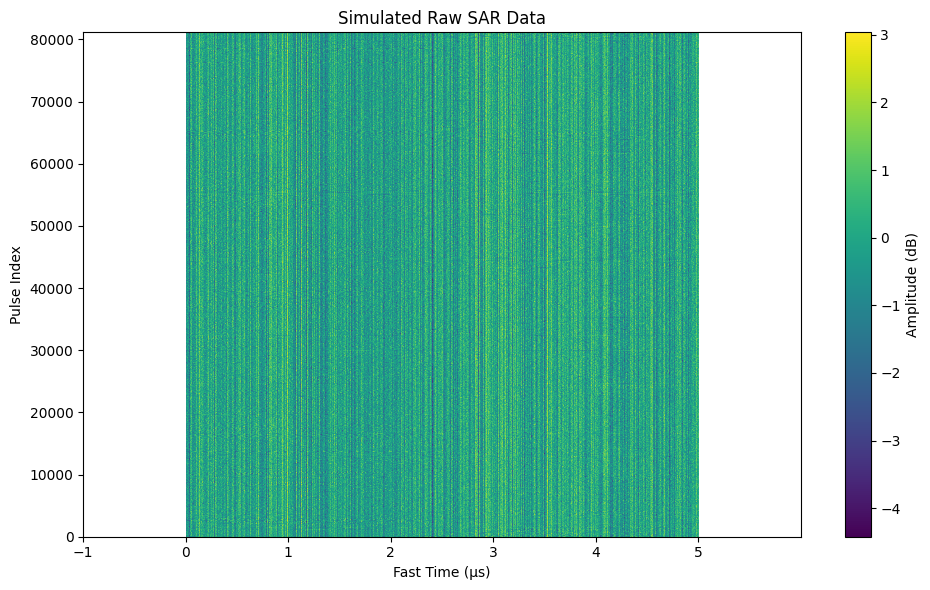

In [39]:
# Plot SAR raw data (Pulse Index vs Fast Time)
plot_raw_sar_data(np.fft.ifftshift(aligned_data), sensor.sampling_frequency_hz, downsample_fast=20)

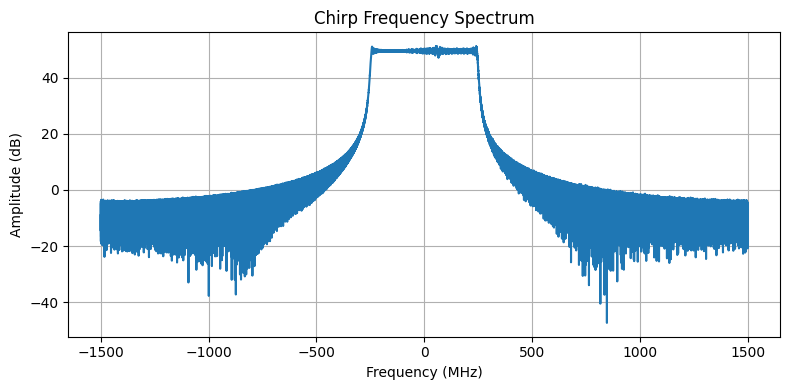

In [40]:
plot_chirp_frequency_spectrum(raw_data[0], sensor.sampling_frequency_hz)

Suggested xlim: (0.0 μs, 5.0 μs)


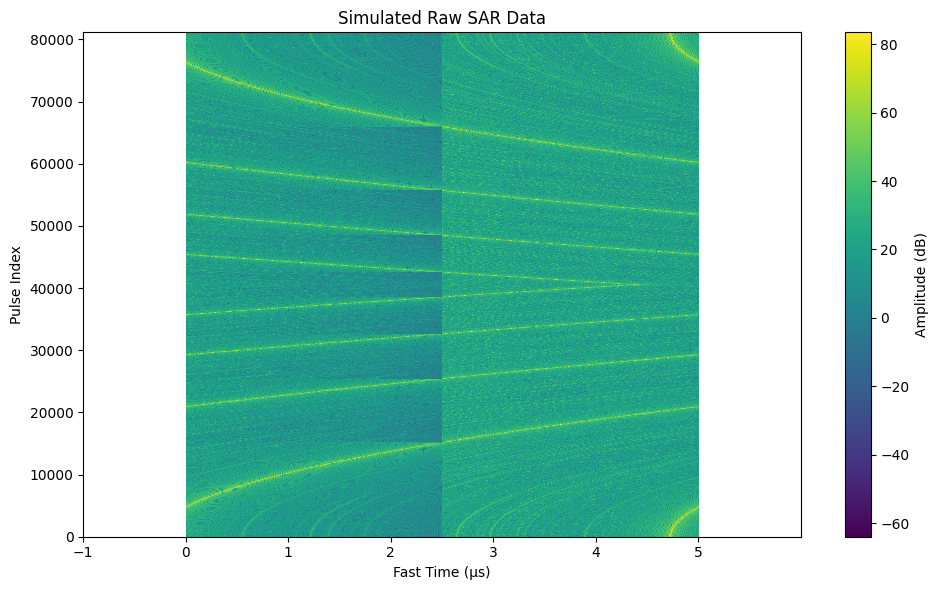

In [41]:
# Perform range compression via matched filtering
compressed_data = simulate_range_compression(raw_data, sensor)

# Plot compressed data
plot_raw_sar_data(np.fft.ifftshift(compressed_data), sensor.sampling_frequency_hz)


In [42]:
# Perform range migration alignment
aligned_data = perform_range_migration(
    compressed_data=compressed_data,
    sensor=sensor,
    target_position=target_pos,
    sampling_frequency=sensor.sampling_frequency_hz
)


Suggested xlim: (0.0 μs, 5.0 μs)


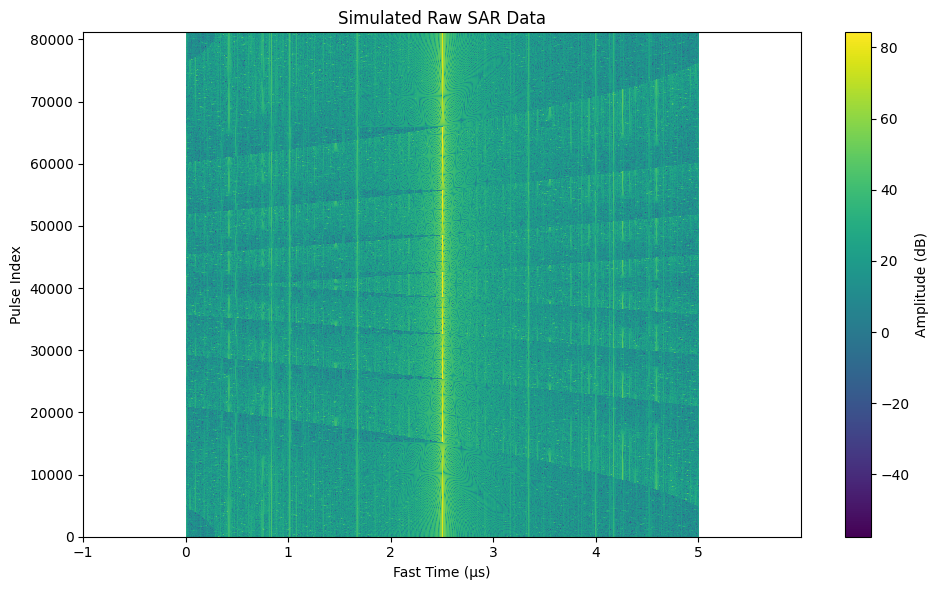

In [43]:
# Plot the aligned data
plot_raw_sar_data(np.fft.ifftshift(aligned_data), sensor.sampling_frequency_hz, downsample_fast=20)

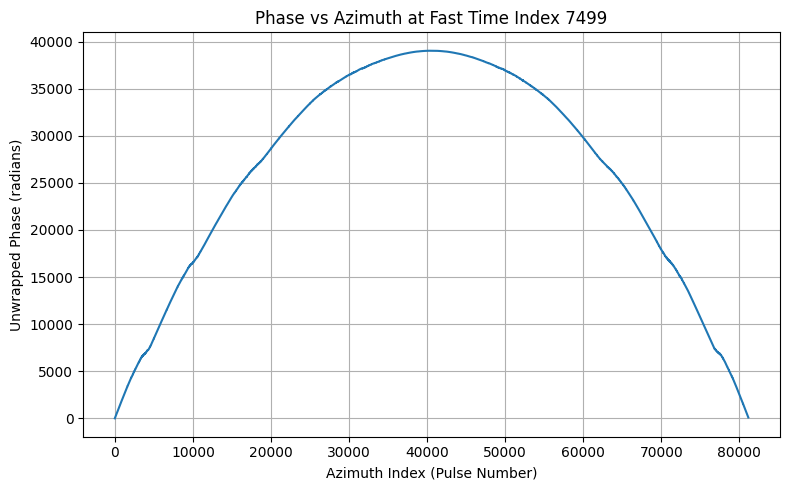

In [44]:
# Check phase vs azimuth
plot_phase_vs_azimuth(aligned_data, sensor.sampling_frequency_hz, fast_time_us=2.5)

In [ ]:
# Perform azimuth compression
reference_azimuth = aligned_data[:, aligned_data.shape[1] // 2]  # Get one column as reference
final_image = simulate_azimuth_compression(aligned_data, reference_azimuth)

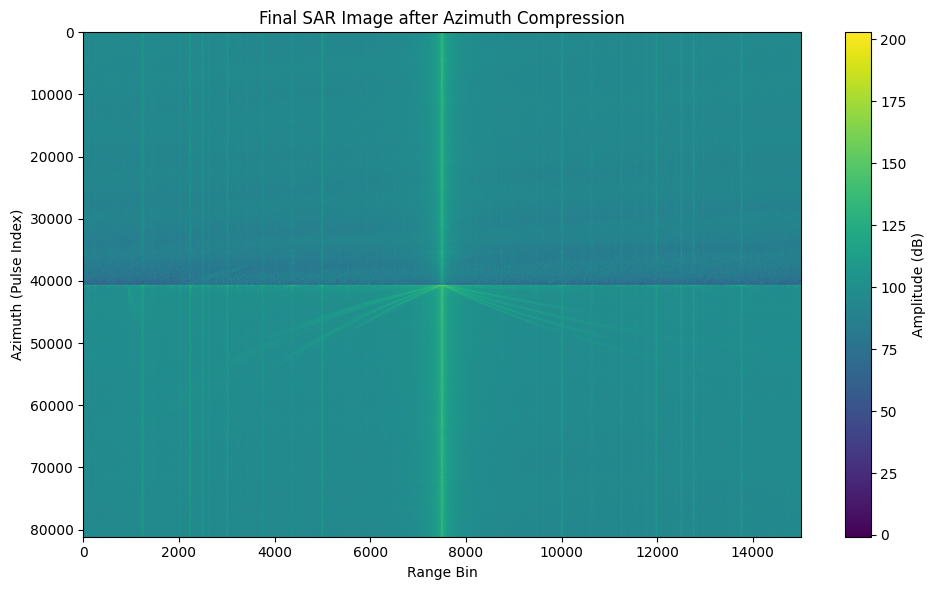

In [48]:
import matplotlib.pyplot as plt
# Plot final SAR image
plt.figure(figsize=(10, 6))
plt.imshow(
    20 * np.log10(np.fft.ifftshift(np.abs(final_image) + 1e-6)),
    aspect='auto', cmap='viridis'
)
plt.colorbar(label='Amplitude (dB)')
plt.xlabel("Range Bin")
plt.ylabel("Azimuth (Pulse Index)")
plt.title("Final SAR Image after Azimuth Compression")
plt.tight_layout()
plt.show()